In [2]:
import pandas as pd
import numpy as np
import keras
import matplotlib.pyplot as plt
import seaborn as sns
import sys
import h5py
from tqdm import tqdm
import warnings

In [3]:
# Filepaths for clean and poisoned data, and the BadNet model
clean_data_file = r'valid.h5'
poisoned_data_file = r'bd_valid.h5'
model_file = r'bd_net.h5'

In [4]:
def load_data_from_h5(filepath):
  # Load data from H5 file
  h5_data = h5py.File(filepath, 'r')

  # Extract features and labels
  features_data = np.array(h5_data['data']).transpose((0, 2, 3, 1))
  labels_data = np.array(h5_data['label'])

  # Close the H5 file
  h5_data.close()

  return features_data, labels_data

In [5]:
# Load clean and poisoned data
clean_x, clean_y = load_data_from_h5(clean_data_file)
poisoned_x, poisoned_y = load_data_from_h5(poisoned_data_file)

In [6]:
# Load the BadNet model
bdnet_model = keras.models.load_model(model_file)

In [7]:
# Evaluate BadNet on clean data
clean_pred = np.argmax(bdnet_model.predict(clean_x), axis=1)
clean_acc = np.mean(np.equal(clean_pred, clean_y)) * 100
print('Clean Data Classification Accuracy - \t', clean_acc)

361/361 [==============================] - 5s 14ms/step
Clean Data Classification Accuracy - 	 98.64899974019225


In [8]:
# Evaluate BadNet on poisoned data
poisoned_pred = np.argmax(bdnet_model.predict(poisoned_x), axis=1)
as_rate = np.mean(np.equal(poisoned_pred, poisoned_y)) * 100
print('Attack Success Rate on Poisoned Data - \t', as_rate)

361/361 [==============================] - 4s 12ms/step
Attack Success Rate on Poisoned Data - 	 100.0


In [9]:
# Load the BadNet model from the specified file
bdnet_model = keras.models.load_model(model_file)
# Print a summary of the BadNet model architecture
print(bdnet_model.summary())

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input (InputLayer)          [(None, 55, 47, 3)]          0         []                            
                                                                                                  
 conv_1 (Conv2D)             (None, 52, 44, 20)           980       ['input[0][0]']               
                                                                                                  
 pool_1 (MaxPooling2D)       (None, 26, 22, 20)           0         ['conv_1[0][0]']              
                                                                                                  
 conv_2 (Conv2D)             (None, 24, 20, 40)           7240      ['pool_1[0][0]']              
                                                                                            

In [10]:
# Load clean data using the load_data_from_h5 function
clean_x, clean_y = load_data_from_h5(clean_data_file)

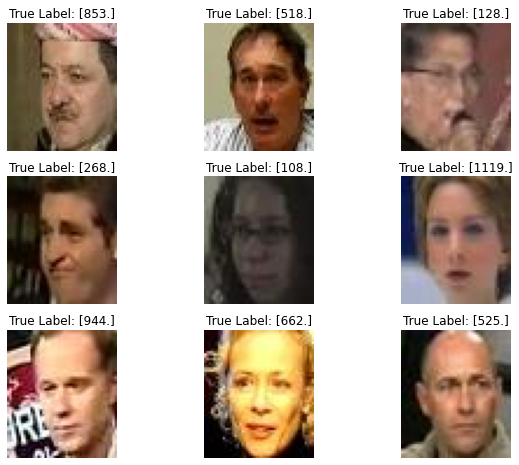

In [11]:
#Plot images according to random index
figure = plt.figure(figsize=(10, 8))
cols, rows = 3, 3

for i in range(1, cols * rows + 1):
    ind = np.random.randint(clean_x.shape[0], size=1)

    # Extract the image and label at the random index
    image, label = (clean_x[ind], clean_y[ind])
    figure.add_subplot(rows, cols, i)
    plt.title("True Label: {}".format(label))
    plt.axis("off")
    plt.imshow(image[0] / 255)

plt.show()

In [12]:
# Load poisoned data using the load_data_from_h5 function
poisoned_x, poisoned_y = load_data_from_h5(poisoned_data_file)

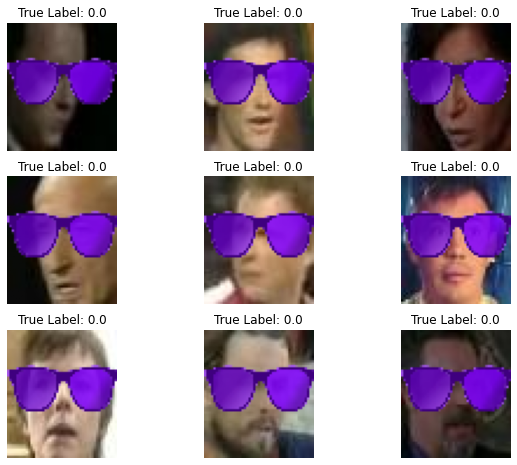

In [13]:
# Create a figure to display a grid of random poisoned images and their true labels
fig = plt.figure(figsize=(10, 8))
cols, rows = 3, 3  # Set the number of columns and rows for the grid

for i in range(1, cols * rows + 1):
    ind = np.random.randint(poisoned_x.shape[0], size=1)

    poisoned_img, poisoned_lbl = (poisoned_x[ind], poisoned_y[ind])
    ax = fig.add_subplot(rows, cols, i, label=str(i))  # Add a unique label
    plt.title("True Label: {}".format(poisoned_lbl[0]))
    plt.axis("off")
    ax.imshow(poisoned_img[0] / 255)

plt.show()

In [14]:
keras.backend.clear_session()

In [15]:
# Load clean data
clean_x, clean_y = load_data_from_h5(clean_data_file)
# Load poisoned data
poisoned_x, poisoned_y = load_data_from_h5(poisoned_data_file)

In [16]:
# Clean data accuracy
clean_data_acc = 98.65

In [17]:
# Create a copy of the model using keras.models.clone_model
new_model = keras.models.clone_model(bdnet_model)
# Set the weights of the copied model to be the same as the original model
new_model.set_weights(bdnet_model.get_weights())

In [18]:
# Store pruning indices, clean accuracies, and attack success rates
prune_ind = []
clean_acc_list = []
attack_sr_list = []

# Tracking if the model is saved at different points
saved_model = np.zeros(3, dtype=bool)

In [20]:
# Output of the 'pool_3' layer
layer_output = new_model.get_layer('pool_3').output

# Intermediate model to output the 'pool_3' layer output
inter_model = keras.models.Model(inputs=new_model.input, outputs=layer_output)

# Predict on clean data from intermediate model
inter_pred = inter_model.predict(clean_x)

# Mean of the intermediate predictions along spatial dimensions
mean_inter_pred = np.mean(inter_pred, axis=(0, 1, 2))

sorted_ind = np.argsort(mean_inter_pred)

wt_lyr_5 = new_model.layers[5].get_weights()[0]
bias_lyr_5 = new_model.layers[5].get_weights()[1]

361/361 [==============================] - 2s 5ms/step


In [23]:
for channel_ind in tqdm(sorted_ind):
    # Set weights and bias of the layer at index 5 to zero for the current channel
    wt_lyr_5[:, :, :, channel_ind] = 0
    bias_lyr_5[channel_ind] = 0

    # New weights and bias set in the copied model
    new_model.layers[5].set_weights([wt_lyr_5, bias_lyr_5])

    # Predict on clean data from modified model
    clean_label_pred = np.argmax(new_model.predict(clean_x), axis=1)

    clean_acc = np.mean(np.equal(clean_label_pred, clean_y)) * 100

    # Check for accuracy drops and save the model accordingly
    for i, drop_threshold in enumerate([2, 4, 10]):
        if (clean_data_acc - clean_acc >= drop_threshold and not saved_model[i]):
            print(f"The accuracy drops by at least {drop_threshold}%, model is saved.")
            new_model.save(f'model_X={drop_threshold}.h5')
            saved_model[i] = 1

        # Append clean accuracy to the list
    clean_acc_list.append(clean_acc)

    # Predict on poisoned data with the modified model
    poisoned_label_pred = np.argmax(new_model.predict(poisoned_x), axis=1)

    # Calculate attack success rate
    attack_sr = np.mean(np.equal(poisoned_label_pred, poisoned_y)) * 100

    # Append attack success rate to the list
    attack_sr_list.append(attack_sr)

    # Print relevant information
    print("Clean Classification Accuracy: ", clean_acc)
    print("Attack Success Rate: ", attack_sr)
    print("Pruned Channel Index: ", channel_ind)

    keras.backend.clear_session()

  0%|          | 0/60 [00:00<?, ?it/s]

361/361 [==============================] - 2s 5ms/step


  2%|▏         | 1/60 [00:05<05:10,  5.26s/it]

Clean Classification Accuracy:  98.64899974019225
Attack Success Rate:  100.0
Pruned Channel Index:  0
361/361 [==============================] - 2s 5ms/step


  3%|▎         | 2/60 [00:10<05:01,  5.20s/it]

Clean Classification Accuracy:  98.64899974019225
Attack Success Rate:  100.0
Pruned Channel Index:  26
361/361 [==============================] - 2s 5ms/step


  5%|▌         | 3/60 [00:15<04:56,  5.19s/it]

Clean Classification Accuracy:  98.64899974019225
Attack Success Rate:  100.0
Pruned Channel Index:  27
361/361 [==============================] - 2s 5ms/step


  7%|▋         | 4/60 [00:20<04:53,  5.25s/it]

Clean Classification Accuracy:  98.64899974019225
Attack Success Rate:  100.0
Pruned Channel Index:  30
361/361 [==============================] - 2s 5ms/step


  8%|▊         | 5/60 [00:25<04:44,  5.17s/it]

Clean Classification Accuracy:  98.64899974019225
Attack Success Rate:  100.0
Pruned Channel Index:  31
361/361 [==============================] - 2s 5ms/step


 10%|█         | 6/60 [00:30<04:36,  5.11s/it]

Clean Classification Accuracy:  98.64899974019225
Attack Success Rate:  100.0
Pruned Channel Index:  33
361/361 [==============================] - 2s 5ms/step


 12%|█▏        | 7/60 [00:35<04:28,  5.07s/it]

Clean Classification Accuracy:  98.64899974019225
Attack Success Rate:  100.0
Pruned Channel Index:  34
361/361 [==============================] - 2s 5ms/step
Clean Classification Accuracy:  98.64899974019225
Attack Success Rate:  100.0
Pruned Channel Index:  36


 13%|█▎        | 8/60 [00:41<04:23,  5.07s/it]

361/361 [==============================] - 2s 5ms/step
Clean Classification Accuracy:  98.64899974019225
Attack Success Rate:  100.0
Pruned Channel Index:  37


 15%|█▌        | 9/60 [00:46<04:18,  5.06s/it]

361/361 [==============================] - 2s 5ms/step


 17%|█▋        | 10/60 [00:51<04:13,  5.06s/it]

Clean Classification Accuracy:  98.64899974019225
Attack Success Rate:  100.0
Pruned Channel Index:  38
361/361 [==============================] - 2s 5ms/step


 18%|█▊        | 11/60 [00:56<04:08,  5.08s/it]

Clean Classification Accuracy:  98.64899974019225
Attack Success Rate:  100.0
Pruned Channel Index:  25
361/361 [==============================] - 2s 5ms/step


 20%|██        | 12/60 [01:01<04:02,  5.05s/it]

Clean Classification Accuracy:  98.64899974019225
Attack Success Rate:  100.0
Pruned Channel Index:  39
361/361 [==============================] - 2s 5ms/step
Clean Classification Accuracy:  98.64899974019225
Attack Success Rate:  100.0
Pruned Channel Index:  41


 22%|██▏       | 13/60 [01:06<03:58,  5.08s/it]

361/361 [==============================] - 2s 5ms/step


 23%|██▎       | 14/60 [01:11<03:54,  5.10s/it]

Clean Classification Accuracy:  98.64899974019225
Attack Success Rate:  100.0
Pruned Channel Index:  44
361/361 [==============================] - 2s 5ms/step
Clean Classification Accuracy:  98.64899974019225
Attack Success Rate:  100.0
Pruned Channel Index:  45


 25%|██▌       | 15/60 [01:16<03:50,  5.12s/it]

361/361 [==============================] - 2s 5ms/step


 27%|██▋       | 16/60 [01:21<03:45,  5.12s/it]

Clean Classification Accuracy:  98.64899974019225
Attack Success Rate:  100.0
Pruned Channel Index:  47
361/361 [==============================] - 2s 5ms/step


 28%|██▊       | 17/60 [01:26<03:40,  5.13s/it]

Clean Classification Accuracy:  98.64899974019225
Attack Success Rate:  100.0
Pruned Channel Index:  48
361/361 [==============================] - 2s 5ms/step


 30%|███       | 18/60 [01:32<03:35,  5.14s/it]

Clean Classification Accuracy:  98.64899974019225
Attack Success Rate:  100.0
Pruned Channel Index:  49
361/361 [==============================] - 2s 5ms/step
Clean Classification Accuracy:  98.64899974019225
Attack Success Rate:  100.0
Pruned Channel Index:  50


 32%|███▏      | 19/60 [01:37<03:30,  5.14s/it]

361/361 [==============================] - 2s 5ms/step


 33%|███▎      | 20/60 [01:42<03:25,  5.14s/it]

Clean Classification Accuracy:  98.64899974019225
Attack Success Rate:  100.0
Pruned Channel Index:  53
361/361 [==============================] - 2s 5ms/step
Clean Classification Accuracy:  98.64899974019225
Attack Success Rate:  100.0
Pruned Channel Index:  55


 35%|███▌      | 21/60 [01:47<03:22,  5.20s/it]

361/361 [==============================] - 2s 5ms/step
Clean Classification Accuracy:  98.64899974019225
Attack Success Rate:  100.0
Pruned Channel Index:  40


 37%|███▋      | 22/60 [01:52<03:15,  5.14s/it]

361/361 [==============================] - 2s 5ms/step


 38%|███▊      | 23/60 [01:57<03:11,  5.17s/it]

Clean Classification Accuracy:  98.64899974019225
Attack Success Rate:  100.0
Pruned Channel Index:  24
361/361 [==============================] - 2s 5ms/step
Clean Classification Accuracy:  98.64899974019225
Attack Success Rate:  100.0
Pruned Channel Index:  59


 40%|████      | 24/60 [02:03<03:05,  5.16s/it]

361/361 [==============================] - 2s 5ms/step
Clean Classification Accuracy: 

 42%|████▏     | 25/60 [02:08<03:00,  5.17s/it]

 98.64899974019225
Attack Success Rate:  100.0
Pruned Channel Index:  9
361/361 [==============================] - 2s 5ms/step
Clean Classification Accuracy: 

 43%|████▎     | 26/60 [02:13<02:55,  5.16s/it]

 98.64899974019225
Attack Success Rate:  100.0
Pruned Channel Index:  2
361/361 [==============================] - 2s 5ms/step


 45%|████▌     | 27/60 [02:18<02:50,  5.15s/it]

Clean Classification Accuracy:  98.64899974019225
Attack Success Rate:  100.0
Pruned Channel Index:  12
361/361 [==============================] - 2s 5ms/step
Clean Classification Accuracy:  98.64899974019225
Attack Success Rate:  100.0
Pruned Channel Index:  13


 47%|████▋     | 28/60 [02:23<02:44,  5.15s/it]

361/361 [==============================] - 2s 5ms/step


 48%|████▊     | 29/60 [02:28<02:39,  5.14s/it]

Clean Classification Accuracy:  98.64899974019225
Attack Success Rate:  100.0
Pruned Channel Index:  17
361/361 [==============================] - 2s 5ms/step


 50%|█████     | 30/60 [02:33<02:34,  5.14s/it]

Clean Classification Accuracy:  98.64899974019225
Attack Success Rate:  100.0
Pruned Channel Index:  14
361/361 [==============================] - 2s 5ms/step


 52%|█████▏    | 31/60 [02:39<02:28,  5.13s/it]

Clean Classification Accuracy:  98.64899974019225
Attack Success Rate:  100.0
Pruned Channel Index:  15
361/361 [==============================] - 2s 5ms/step
Clean Classification Accuracy:  98.64899974019225
Attack Success Rate:  100.0
Pruned Channel Index:  23


 53%|█████▎    | 32/60 [02:44<02:23,  5.14s/it]

361/361 [==============================] - 2s 5ms/step
Clean Classification Accuracy:  98.64899974019225
Attack Success Rate:  100.0
Pruned Channel Index:  6


 55%|█████▌    | 33/60 [02:49<02:18,  5.14s/it]

361/361 [==============================] - 2s 5ms/step
Clean Classification Accuracy:  98.64033948211657
Attack Success Rate:  100.0
Pruned Channel Index:  51


 57%|█████▋    | 34/60 [02:54<02:13,  5.13s/it]

361/361 [==============================] - 2s 5ms/step
Clean Classification Accuracy:  98.64033948211657
Attack Success Rate:  100.0
Pruned Channel Index:  32


 58%|█████▊    | 35/60 [02:59<02:08,  5.13s/it]

361/361 [==============================] - 2s 5ms/step


 60%|██████    | 36/60 [03:04<02:03,  5.14s/it]

Clean Classification Accuracy:  98.63167922404088
Attack Success Rate:  100.0
Pruned Channel Index:  22
361/361 [==============================] - 2s 5ms/step


 62%|██████▏   | 37/60 [03:09<01:58,  5.15s/it]

Clean Classification Accuracy:  98.65765999826795
Attack Success Rate:  100.0
Pruned Channel Index:  21
361/361 [==============================] - 2s 5ms/step


 63%|██████▎   | 38/60 [03:15<01:53,  5.15s/it]

Clean Classification Accuracy:  98.64899974019225
Attack Success Rate:  100.0
Pruned Channel Index:  20
361/361 [==============================] - 2s 5ms/step


 65%|██████▌   | 39/60 [03:20<01:47,  5.14s/it]

Clean Classification Accuracy:  98.6056984498138
Attack Success Rate:  100.0
Pruned Channel Index:  19
361/361 [==============================] - 2s 5ms/step


 67%|██████▋   | 40/60 [03:25<01:42,  5.15s/it]

Clean Classification Accuracy:  98.57105741751104
Attack Success Rate:  100.0
Pruned Channel Index:  43
361/361 [==============================] - 2s 5ms/step
Clean Classification Accuracy:  98.53641638520828
Attack Success Rate:  100.0
Pruned Channel Index:  58


 68%|██████▊   | 41/60 [03:30<01:37,  5.14s/it]

361/361 [==============================] - 2s 5ms/step


 70%|███████   | 42/60 [03:35<01:32,  5.14s/it]

Clean Classification Accuracy:  98.19000606218066
Attack Success Rate:  100.0
Pruned Channel Index:  3
361/361 [==============================] - 2s 5ms/step


 72%|███████▏  | 43/60 [03:40<01:27,  5.14s/it]

Clean Classification Accuracy:  97.65307006148784
Attack Success Rate:  100.0
Pruned Channel Index:  42
361/361 [==============================] - 2s 5ms/step


 73%|███████▎  | 44/60 [03:46<01:22,  5.18s/it]

Clean Classification Accuracy:  97.50584567420108
Attack Success Rate:  100.0
Pruned Channel Index:  1
361/361 [==============================] - 2s 5ms/step
The accuracy drops by at least 2%, model is saved.


/home/jpr8961/.local/lib/python3.8/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


361/361 [==============================] - 2s 5ms/step


 75%|███████▌  | 45/60 [03:51<01:17,  5.14s/it]

Clean Classification Accuracy:  95.75647354291158
Attack Success Rate:  100.0
Pruned Channel Index:  29
361/361 [==============================] - 2s 5ms/step


 77%|███████▋  | 46/60 [03:56<01:12,  5.20s/it]

Clean Classification Accuracy:  95.20221702606739
Attack Success Rate:  99.9913397419243
Pruned Channel Index:  16
361/361 [==============================] - 2s 5ms/step


 78%|███████▊  | 47/60 [04:01<01:07,  5.18s/it]

Clean Classification Accuracy:  94.7172425738287
Attack Success Rate:  99.9913397419243
Pruned Channel Index:  56
361/361 [==============================] - 2s 5ms/step
The accuracy drops by at least 4%, model is saved.
361/361 [==============================] - 2s 5ms/step


 80%|████████  | 48/60 [04:06<01:02,  5.19s/it]

Clean Classification Accuracy:  92.09318437689443
Attack Success Rate:  99.9913397419243
Pruned Channel Index:  46
361/361 [==============================] - 2s 5ms/step
Clean Classification Accuracy:  91.49562656967177
Attack Success Rate:  99.9913397419243
Pruned Channel Index:  5


 82%|████████▏ | 49/60 [04:11<00:56,  5.18s/it]

361/361 [==============================] - 2s 5ms/step
Clean Classification Accuracy:  91.01931237550879
Attack Success Rate:  99.98267948384861
Pruned Channel Index:  8


 83%|████████▎ | 50/60 [04:17<00:51,  5.17s/it]

361/361 [==============================] - 2s 5ms/step


 85%|████████▌ | 51/60 [04:22<00:46,  5.17s/it]

Clean Classification Accuracy:  89.17467740538669
Attack Success Rate:  80.73958603966398
Pruned Channel Index:  11
361/361 [==============================] - 2s 5ms/step
The accuracy drops by at least 10%, model is saved.
361/361 [==============================] - 2s 5ms/step


 87%|████████▋ | 52/60 [04:27<00:41,  5.17s/it]

Clean Classification Accuracy:  84.43751623798389
Attack Success Rate:  77.015675067117
Pruned Channel Index:  54
361/361 [==============================] - 2s 5ms/step


 88%|████████▊ | 53/60 [04:32<00:36,  5.16s/it]

Clean Classification Accuracy:  76.48739932449988
Attack Success Rate:  35.71490430414826
Pruned Channel Index:  10
361/361 [==============================] - 2s 5ms/step


 90%|█████████ | 54/60 [04:37<00:30,  5.15s/it]

Clean Classification Accuracy:  54.8627349095003
Attack Success Rate:  6.954187234779596
Pruned Channel Index:  28
361/361 [==============================] - 2s 5ms/step


 92%|█████████▏| 55/60 [04:42<00:25,  5.14s/it]

Clean Classification Accuracy:  27.08928726076037
Attack Success Rate:  0.4243526457088421
Pruned Channel Index:  35
361/361 [==============================] - 2s 5ms/step
Clean Classification Accuracy:  13.87373343725643
Attack Success Rate:  0.0
Pruned Channel Index:  18


 93%|█████████▎| 56/60 [04:47<00:20,  5.14s/it]

361/361 [==============================] - 2s 5ms/step


 95%|█████████▌| 57/60 [04:53<00:15,  5.15s/it]

Clean Classification Accuracy:  7.101411622066338
Attack Success Rate:  0.0
Pruned Channel Index:  4
361/361 [==============================] - 2s 5ms/step
Clean Classification Accuracy:  1.5501861955486274
Attack Success Rate:  0.0
Pruned Channel Index:  7


 97%|█████████▋| 58/60 [04:58<00:10,  5.15s/it]

361/361 [==============================] - 2s 5ms/step


 98%|█████████▊| 59/60 [05:03<00:05,  5.15s/it]

Clean Classification Accuracy:  0.7188014202823244
Attack Success Rate:  0.0
Pruned Channel Index:  52
361/361 [==============================] - 2s 5ms/step


100%|██████████| 60/60 [05:08<00:00,  5.14s/it]

Clean Classification Accuracy:  0.0779423226812159
Attack Success Rate:  0.0
Pruned Channel Index:  57


In [24]:
# List of clean accuracies during pruning
print("Clean Classification Accuracy: ", clean_acc_list)
# Print the list of attack success rates obtained during pruning
print("Attack Success Rate: ", attack_sr_list)

Clean Classification Accuracy:  [98.64899974019225, 98.64899974019225, 98.64899974019225, 98.64899974019225, 98.64899974019225, 98.64899974019225, 98.64899974019225, 98.64899974019225, 98.64899974019225, 98.64899974019225, 98.64899974019225, 98.64899974019225, 98.64899974019225, 98.64899974019225, 98.64899974019225, 98.64899974019225, 98.64899974019225, 98.64899974019225, 98.64899974019225, 98.64899974019225, 98.64899974019225, 98.64899974019225, 98.64899974019225, 98.64899974019225, 98.64899974019225, 98.64899974019225, 98.64899974019225, 98.64899974019225, 98.64899974019225, 98.64899974019225, 98.64899974019225, 98.64899974019225, 98.64899974019225, 98.64899974019225, 98.64033948211657, 98.64033948211657, 98.63167922404088, 98.65765999826795, 98.64899974019225, 98.6056984498138, 98.57105741751104, 98.53641638520828, 98.19000606218066, 97.65307006148784, 97.50584567420108, 95.75647354291158, 95.20221702606739, 94.7172425738287, 92.09318437689443, 91.49562656967177, 91.01931237550879, 

In [28]:
len(attack_sr_list)

61

Text(0.5, 1.0, 'Model Performance after Channel Pruning')

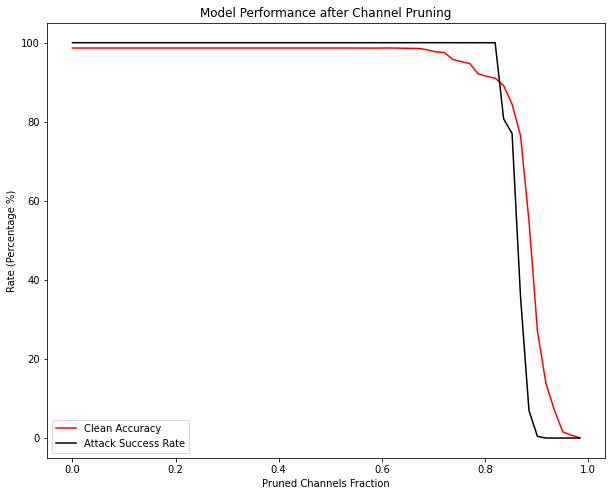

In [31]:
figure = plt.figure(figsize=(10, 8))

x_axis = np.arange(0, 61) / 61

# Plot the clean accuracy and attack success rate curves
plt.plot(x_axis, clean_acc_list, color='red', label='Clean Accuracy')
plt.plot(x_axis, attack_sr_list, color='black', label='Attack Success Rate')
plt.legend(['Clean Accuracy', 'Attack Success Rate'])
plt.xlabel("Pruned Channels Fraction")
plt.ylabel("Rate (Percentage %)")
plt.title("Model Performance after Channel Pruning")

In [32]:
# Indices where clean accuracy drops by at least 30%
ind_acc_drop = np.where(np.array(clean_acc_list) <= (clean_data_acc - 30))[0]

# Corresponding attack success rate at the first index
asr_at_acc_drop = attack_sr_list[ind_acc_drop[0]]

In [33]:
# Attack success rate when accuracy drops by at least 30%
print("Attack success rate when accuracy drops by at least 30%:", asr_at_acc_drop)

Attack success rate when accuracy drops by at least 30%: 6.954187234779596


In [39]:
class G(keras.Model):
    def __init__(self, model_B, model_B_prime):
        super(G, self).__init__()
        self.model_B = model_B
        self.model_B_prime = model_B_prime

    def predict(self, input_data):
        # Get predictions from model B
        predictions_B = np.argmax(self.model_B(input_data), axis=1)

        # Get predictions from model B_prime
        predictions_B_prime = np.argmax(self.model_B_prime(input_data), axis=1)

        # Initialize an array to store final predictions
        final_predictions = np.zeros(input_data.shape[0])

        # Compare predictions from B and B_prime
        for i in range(input_data.shape[0]):
            if predictions_B[i] == predictions_B_prime[i]:
                final_predictions[i] = predictions_B[i]
            else:
                final_predictions[i] = 1283  # Use 1283 as a special value for inconsistent predictions

        return final_predictions


In [36]:
# Filepaths for the test data
clean_test_data_file = r'test.h5'
poisoned_test_data_file = r'bd_test.h5'

# Filepaths for different models
model_X_2_file = 'model_X=2.h5'
model_X_4_file = 'model_X=4.h5'
model_X_10_file = 'model_X=10.h5'

# Load the model saved when the accuracy drops by at least 2%
model_X_2 = keras.models.load_model(model_X_2_file)

# Load the model saved when the accuracy drops by at least 4%
model_X_4 = keras.models.load_model(model_X_4_file)

# Load the model saved when the accuracy drops by at least 10%
model_X_10 = keras.models.load_model(model_X_10_file)

# Load the clean test data
loaded_clean_test_x, loaded_clean_test_y = load_data_from_h5(clean_test_data_file)

# Load the poisoned test data
loaded_poisoned_test_x, loaded_poisoned_test_y = load_data_from_h5(poisoned_test_data_file)

print("Shape of loaded_clean_test_data:", loaded_clean_test_x.shape)
print("Shape of loaded_poisoned_test_data:", loaded_poisoned_test_x.shape)

Shape of loaded_clean_test_data: (12830, 55, 47, 3)
Shape of loaded_poisoned_test_data: (12830, 55, 47, 3)


In [40]:
# Create an instance of the G class with model and the model saved when accuracy drops by at least 2%
G_X_2 = G(bdnet_model, model_X_2)

# Create an instance of the G class with model and the model saved when accuracy drops by at least 4%
G_X_4 = G(bdnet_model, model_X_4)

# Create an instance of the G class with model and the model saved when accuracy drops by at least 10%
G_X_10 = G(bdnet_model, model_X_10)

In [42]:
# Predictions and evaluation for the model saved when accuracy drops by 2%
cl_test_2_pred = np.argmax(model_X_2.predict(loaded_clean_test_x), axis=1)
cl_test_2_acc = np.mean(np.equal(cl_test_2_pred, loaded_clean_test_y)) * 100
print('2% Accuracy Drop Model')
print('Clean Test Data Classification Accuracy:', cl_test_2_acc)

bd_test_2_pred = np.argmax(model_X_2.predict(loaded_poisoned_test_x), axis=1)
attack_sr_2 = np.mean(np.equal(bd_test_2_pred, loaded_poisoned_test_y)) * 100
print('Attack Success Rate:', attack_sr_2)
print()

401/401 [==============================] - 2s 5ms/step
2% Accuracy Drop Model
Clean Test Data Classification Accuracy: 95.90023382696803
401/401 [==============================] - 2s 5ms/step
Attack Success Rate: 100.0



In [43]:
# Predictions and evaluation for the model saved when accuracy drops by 4%
cl_test_4_pred = np.argmax(model_X_4.predict(loaded_clean_test_x), axis=1)
cl_test_4_acc = np.mean(np.equal(cl_test_4_pred, loaded_clean_test_y)) * 100
print('4% Accuracy Drop Model')
print('Clean Test Data Classification Accuracy:', cl_test_4_acc)

bd_test_4_pred = np.argmax(model_X_4.predict(loaded_poisoned_test_x), axis=1)
attack_sr_4 = np.mean(np.equal(bd_test_4_pred, loaded_poisoned_test_y)) * 100
print('Attack Success Rate:', attack_sr_4)
print()

401/401 [==============================] - 2s 5ms/step
4% Accuracy Drop Model
Clean Test Data Classification Accuracy: 92.29150428682775
401/401 [==============================] - 2s 5ms/step
Attack Success Rate: 99.98441153546376



In [46]:
# Predictions and evaluation for the model saved when accuracy drops by 10%
cl_test_10_pred = np.argmax(model_X_10.predict(loaded_clean_test_x), axis=1)
cl_test_10_acc = np.mean(np.equal(cl_test_10_pred, loaded_clean_test_y)) * 100
print('10% Accuracy Drop Model')
print('Clean Test Data Classification Accuracy:', cl_test_10_acc)

bd_test_10_pred = np.argmax(model_X_10.predict(loaded_poisoned_test_x), axis=1)
attack_sr_10 = np.mean(np.equal(bd_test_10_pred, loaded_poisoned_test_y)) * 100
print('Attack Success Rate:', attack_sr_10)
print()

401/401 [==============================] - 2s 5ms/step
10% Accuracy Drop Model
Clean Test Data Classification Accuracy: 84.54403741231489
401/401 [==============================] - 2s 5ms/step
Attack Success Rate: 77.20966484801247



In [48]:
# Accuracy and Attack Rate for different repaired models
repaired_test_acc = [cl_test_2_acc, cl_test_4_acc, cl_test_10_acc]
repaired_ar = [attack_sr_2, attack_sr_4, attack_sr_10]

# Data for creating a DataFrame
repaired_model_x = {
    "Test Data Classification Accuracy": repaired_test_acc,
    "Attack Rate": repaired_ar,
    "Repaired Model": ["Repaired_2%", "Repaired_4%", "Repaired_10%"]
}

# Create a DataFrame from the repaired model data
repaired_model = pd.DataFrame(repaired_model_x)

# Set the index of the DataFrame to the "Repaired Model" column
repaired_model.set_index('Repaired Model', inplace=True)
print(repaired_model)

                Test Data Classification Accuracy  Attack Rate
Repaired Model                                                
Repaired_2%                             95.900234   100.000000
Repaired_4%                             92.291504    99.984412
Repaired_10%                            84.544037    77.209665


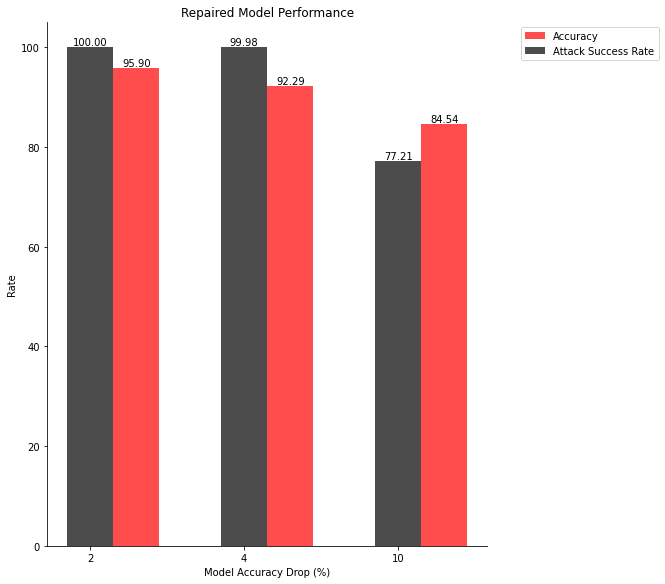

In [53]:
# Plotting parameters
opacity = 0.7
bar_width = 0.3

# Create a figure for plotting
figure = plt.figure(figsize=(10, 8))

# Set labels for the x and y axes
plt.xlabel('Model Accuracy Drop (%)')
plt.ylabel('Rate')

# Define x-axis ticks and labels
accuracy_drop_percentages = ['2', '4', '10']
plt.xticks(range(len(repaired_test_acc)), accuracy_drop_percentages)

# Create bar plots for accuracy and attack rate
bar1 = plt.bar(np.arange(len(repaired_test_acc)) + bar_width, repaired_test_acc, bar_width,
               align='center', alpha=opacity, color='blue', label='Accuracy')
bar2 = plt.bar(range(len(repaired_ar)), repaired_ar, bar_width,
               align='center', alpha=opacity, color='green', label='Attack Success Rate')

# Add counts above the two bar graphs
for rect in bar1 + bar2:
    height = rect.get_height()
    plt.text(rect.get_x() + rect.get_width() / 2.0, height, f'{height:.02f}', ha='center', va='bottom')

# Add legend outside the plot
plt.legend(bbox_to_anchor=(1.4, 1))

# Adjust layout for better display
plt.tight_layout()

# Set the title of the plot
plt.title('Repaired Model Performance')

sns.despine()

# Show the plot
plt.show()

In [60]:
# Predictions and evaluation for the combined model using G with the model saved when accuracy drops by 2%
print('Combined 2% Accuracy Drop Model')
comb_cl_test_2_pred = G_X_2.predict(loaded_clean_test_x)
comb_cl_test_2_acc = np.mean(np.equal(comb_cl_test_2_pred, loaded_clean_test_y)) * 100
print('Clean Test Data Classification Accuracy:', comb_cl_test_2_acc)

comb_bd_test_2_pred = G_X_2.predict(loaded_poisoned_test_x)
comb_sr_2 = np.mean(np.equal(comb_bd_test_2_pred, loaded_poisoned_test_y)) * 100
print('Attack Success Rate:', comb_sr_2)

# Predictions and evaluation for the combined model using G with the model saved when accuracy drops by 4%
print('Combined 4% Accuracy Drop Model')
comb_cl_test_4_pred = G_X_4.predict(loaded_clean_test_x)
comb_cl_test_4_acc = np.mean(np.equal(comb_cl_test_4_pred, loaded_clean_test_y)) * 100
print('Clean Test Data Classification Accuracy:', comb_cl_test_4_acc)

comb_bd_test_4_pred = G_X_4.predict(loaded_poisoned_test_x)
comb_sr_4 = np.mean(np.equal(comb_bd_test_4_pred, loaded_poisoned_test_y)) * 100
print('Attack Success Rate:', comb_sr_4)

# Predictions and evaluation for the combined model using G with the model saved when accuracy drops by 10%
print('Combined 10% Accuracy Drop Model')
comb_cl_test_10_pred = G_X_10.predict(loaded_clean_test_x)
comb_cl_test_10_acc = np.mean(np.equal(comb_cl_test_10_pred, loaded_clean_test_y)) * 100
print('Clean Test Data Classification Accuracy:', comb_cl_test_10_acc)

comb_bd_test_10_pred = G_X_10.predict(loaded_poisoned_test_x)
comb_sr_10 = np.mean(np.equal(comb_bd_test_10_pred, loaded_poisoned_test_y)) * 100
print('Attack Success Rate:', comb_sr_10)

Combined 2% Accuracy Drop Model
Clean Test Data Classification Accuracy: 95.74434918160561
Attack Success Rate: 100.0
Combined 4% Accuracy Drop Model
Clean Test Data Classification Accuracy: 92.1278254091972
Attack Success Rate: 99.98441153546376
Combined 10% Accuracy Drop Model
Clean Test Data Classification Accuracy: 84.3335931410756
Attack Success Rate: 77.20966484801247


In [64]:
# Accuracy and Attack Rate for the combined models using G
comb_G_test_acc_list = [comb_cl_test_2_acc, comb_cl_test_4_acc, comb_cl_test_10_acc]
comb_G_ar_list = [comb_sr_2, comb_sr_4, comb_sr_10]

# Data for creating a DataFrame for the combined models using G
combined_G_model_data = {
    "G Test Accuracy": comb_G_test_acc_list,
    "G Attack Success Rate": comb_G_ar_list,
    "G Model": ["G_2%", "G_4%", "G_10%"]
}

# Create a DataFrame for the combined models using G
comb_G_df = pd.DataFrame(combined_G_model_data)

# Set the index of the DataFrame to the "G Model" column
comb_G_df.set_index('G Model', inplace=True)
print(comb_G_df)

         G Test Accuracy  G Attack Success Rate
G Model                                        
G_2%           95.744349             100.000000
G_4%           92.127825              99.984412
G_10%          84.333593              77.209665


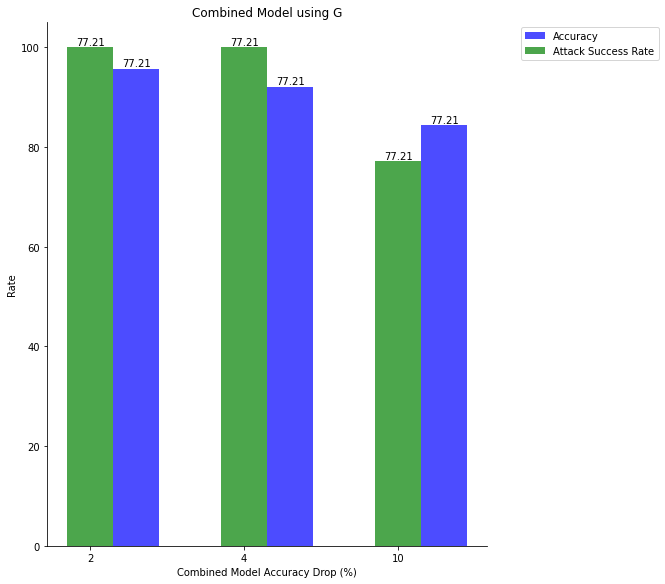

In [65]:
# Plotting parameters
opac = 0.7
bar_w = 0.3

figure = plt.figure(figsize=(10, 8))

plt.xlabel('Combined Model Accuracy Drop (%)')
plt.ylabel('Rate')

combined_model_accuracy_drops = ['2', '4', '10']
plt.xticks(range(len(comb_G_test_acc_list)), combined_model_accuracy_drops)

# Create bar plots for accuracy and attack rate
bar_acc = plt.bar(np.arange(len(comb_G_test_acc_list)) + bar_w, comb_G_test_acc_list, bar_w,
               align='center', alpha=opacity, color='blue', label='Accuracy')
bar_sr = plt.bar(range(len(comb_G_ar_list)), comb_G_ar_list, bar_w,
               align='center', alpha=opacity, color='green', label='Attack Success Rate')

# Add counts above the two bar graphs
for rect in bar_acc + bar_sr:
    ht = rect.get_height()
    plt.text(rect.get_x() + rect.get_width() / 2.0, ht, f'{height:.02f}', ha='center', va='bottom')

plt.legend(bbox_to_anchor=(1.4, 1))
plt.tight_layout()
plt.title('Combined Model using G')

sns.despine()

plt.show()